# [Deep Learning](https://github.com/M-Sc-AUT/M.Sc-Computer-Architecture/tree/main/Deep%20Learning) - Spring 2024
#### [Reza Adinepour](https://github.com/rezaAdinepour)
#### Stu.ID: 402131055

## Question 2 Part A:
We should load dataset ($\texttt{dataset\_1.csv}$ file) as a train dataset

### Import libraries

In [131]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from torch.utils.data import DataLoader, TensorDataset

### Check GPU availability

In [132]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Read dataset and data visualization

In [133]:
df = pd.read_csv("../inputs/dataset_1.csv")

# shuffling dataset
df = shuffle(df)

# split dataset into the inputs x and the outputs y (labels)
X = df[['x', 'y']]
y = df['label']

print("shape of data frame is:", df.shape)
df

shape of data frame is: (100000, 3)


,x,y,label
49511,21.99261,-101.37728,1.0
59612,58.59145,77.49663,0.0
59153,34.60410,67.53922,1.0
47725,26.36642,97.32118,0.0
7873,68.90720,-3.09690,1.0
...,...,...,...
54317,66.47274,32.64818,1.0
70668,-30.35532,52.36910,0.0
9260,-24.40048,30.65130,1.0
81529,-1.93277,58.85783,0.0


### Convert data to pytorch tensors

In [134]:
X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y.values, dtype=torch.float32).to(device).view(-1, 1)

print("Training set size:", len(X_tensor))
X_tensor

Training set size: 100000


tensor([[  21.9926, -101.3773],
        [  58.5914,   77.4966],
        [  34.6041,   67.5392],
        ...,
        [ -24.4005,   30.6513],
        [  -1.9328,   58.8578],
        [  36.3605,  -49.9261]], device='cuda:0')

### Split classes

In [135]:
class0 = X_tensor[y_tensor.flatten() == 0]
class1 = X_tensor[y_tensor.flatten() == 1]

### Plot dataset

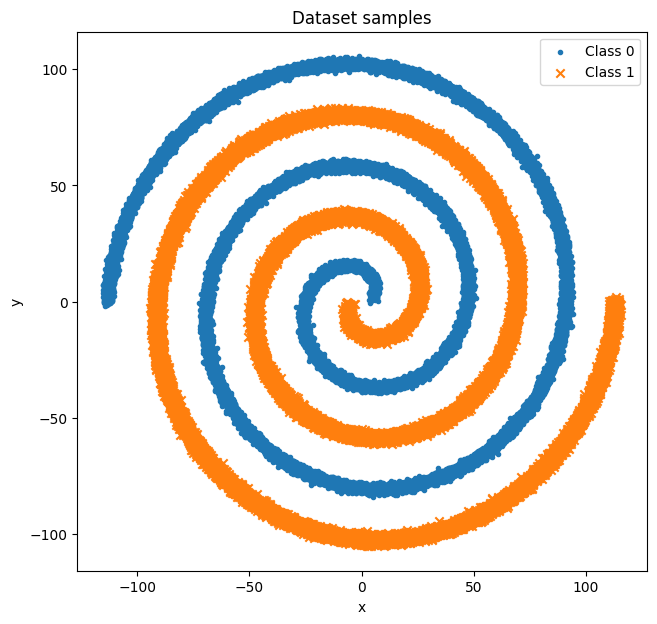

In [136]:
plt.figure(figsize=(25, 7))

plt.subplot(1, 3, 1)
plt.scatter(class0[:, 0].cpu().numpy(), class0[:, 1].cpu().numpy(), label="Class 0", marker='.')
plt.scatter(class1[:, 0].cpu().numpy(), class1[:, 1].cpu().numpy(), label="Class 1", marker='x')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Dataset samples")
plt.legend()

plt.show()

### Split dataset into the 50 subsets

In [137]:
num_subsets = 50
num_samples_per_class = min(len(class0), len(class1)) // num_subsets


subsets = []
for i in range(num_subsets):
    subset_class0 = class0[i * num_samples_per_class : (i + 1) * num_samples_per_class]
    subset_class1 = class1[i * num_samples_per_class : (i + 1) * num_samples_per_class]
    subset = torch.cat((subset_class0, subset_class1), dim=0)
    subsets.append(subset)


for i, subset in enumerate(subsets):
    print(f"subset {i+1}: {subset.shape}")

subset 1: torch.Size([2000, 2])
subset 2: torch.Size([2000, 2])
subset 3: torch.Size([2000, 2])
subset 4: torch.Size([2000, 2])
subset 5: torch.Size([2000, 2])
subset 6: torch.Size([2000, 2])
subset 7: torch.Size([2000, 2])
subset 8: torch.Size([2000, 2])
subset 9: torch.Size([2000, 2])
subset 10: torch.Size([2000, 2])
subset 11: torch.Size([2000, 2])
subset 12: torch.Size([2000, 2])
subset 13: torch.Size([2000, 2])
subset 14: torch.Size([2000, 2])
subset 15: torch.Size([2000, 2])
subset 16: torch.Size([2000, 2])
subset 17: torch.Size([2000, 2])
subset 18: torch.Size([2000, 2])
subset 19: torch.Size([2000, 2])
subset 20: torch.Size([2000, 2])
subset 21: torch.Size([2000, 2])
subset 22: torch.Size([2000, 2])
subset 23: torch.Size([2000, 2])
subset 24: torch.Size([2000, 2])
subset 25: torch.Size([2000, 2])
subset 26: torch.Size([2000, 2])
subset 27: torch.Size([2000, 2])
subset 28: torch.Size([2000, 2])
subset 29: torch.Size([2000, 2])
subset 30: torch.Size([2000, 2])
subset 31: torch.Si

In [138]:
for i, loader in enumerate(subsets):
    print(f"Subset {i+1}:")
    print(loader)
    print('-' * 50)

Subset 1:
tensor([[ 58.5914,  77.4966],
        [ 26.3664,  97.3212],
        [ 43.9876,  27.7710],
        ...,
        [112.7047,  -5.5055],
        [ -7.9324,  37.9905],
        [ 94.6179, -54.6066]], device='cuda:0')
--------------------------------------------------
Subset 2:
tensor([[ 11.1433,  53.8679],
        [ 39.7445, -22.9571],
        [ 32.4025,  95.5226],
        ...,
        [ 71.1093, -78.5749],
        [-91.0326,  11.1383],
        [-90.1486, -18.7395]], device='cuda:0')
--------------------------------------------------
Subset 3:
tensor([[ 89.3092,  20.1451],
        [-68.5588, -16.1151],
        [  1.3613, -79.4915],
        ...,
        [ 77.3279, -74.4275],
        [ 68.6333,   0.8827],
        [-44.0191,  11.7569]], device='cuda:0')
--------------------------------------------------
Subset 4:
tensor([[ 91.6891,   7.3674],
        [ 76.3899,  56.3234],
        [-12.5966,  58.6090],
        ...,
        [ 13.4446,  78.4403],
        [-85.6647, -34.0354],
        [10

### Design MLP network

In [141]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Utility functions for create network

In [142]:
# function to create a new MLP with different initialization
def create_mlp(input_size, hidden_size, output_size):
    model = MLP(input_size, hidden_size, output_size)
    model.apply(init_weights)
    return model

# function to initialize weights
def init_weights(m):
    if(isinstance(m, nn.Linear)):
        torch.nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0.01)

### Set parameters of network

In [147]:
input_size = 2
hidden_size = 64
output_size = 1

num_networks = 5
mlp_networks = [create_mlp(input_size, hidden_size, output_size) for _ in range(num_networks)]

# different initializations
for i, net in enumerate(mlp_networks):
    print(f"Network {i+1}:")
    for name, param in net.named_parameters():
        if(param.requires_grad):
            print(name, param.data)
    print('-' * 50)

Network 1:
fc1.weight tensor([[-0.3550,  0.1449],
        [-0.0221, -0.8971],
        [-1.2359,  1.2547],
        [-0.1972, -0.0546],
        [-0.5432,  1.7020],
        [ 1.2092,  0.5014],
        [-0.0542, -1.0221],
        [-0.2690,  1.0734],
        [-0.3875, -1.3065],
        [-1.5529,  0.9907],
        [ 0.2117,  0.5285],
        [-0.3827,  0.7280],
        [ 0.8067, -1.5016],
        [-1.7084,  0.1777],
        [-1.0749,  1.1496],
        [ 1.0488, -1.0166],
        [-0.1416, -1.4611],
        [-1.1535,  0.3572],
        [-0.1866,  0.6260],
        [-1.1449, -1.5915],
        [ 1.5717, -1.2225],
        [ 0.5812,  0.5954],
        [-0.5876, -0.2626],
        [-1.5128,  0.8742],
        [-1.1454,  1.4909],
        [-1.1759,  0.1496],
        [ 1.1734,  1.3288],
        [-0.3960,  0.7553],
        [ 0.5046, -1.5490],
        [-1.3503, -0.3259],
        [-0.9914, -0.5838],
        [-1.2297,  0.6052],
        [-0.9062,  0.3474],
        [-0.4831, -0.7639],
        [-1.1671,  0.5577]